In [1]:
from IPython.display import Markdown, display

display(Markdown("README.md"))

# The Unsupervised Learning Trick

**Purpose:** Show the unsupervised learning trick on the mnist data using a Random Forest.

The unsupervised learning trick is done by creating a new class in a classification problem using simulated data.

The data is simulated by randomly sampling from the **univariate empirical distribution** for each feature (not the **multivariate empirical distribution**).
For this new class each feature is independent wrt. the empirical distribution:

$$\mathbb{P}(X_1, \dots, X_n) = \mathbb{P}(X_1) \cdots \mathbb{P}(X_n)$$

As explained by Adele Cutler in [1]:

The Unsupervised Learning Trick. Label the “real” data as class 1. Construct cases from a synthetic second class as follows:

1. Randomly select the value for variable 1 from all the observed values of variable 1.
2. Independently, randomly select the value for variable 2 from all the observed values of variable 2.
3. Similarly for variables 3,...,M.

The Synthetic Second Class. The synthetic second class has the same marginal distributions as the “real” data, but we have destroyed all the dependencies between the variables. Now we have a 2-class classification problem.

Run random forests !

## References

[1] Slide 57-58. state-of-the-art-data-mining-using-random-forest-leo-breiman-adele-cutler.pdf

[2] http://yann.lecun.com/exdb/mnist/


In [2]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import dataclasses
import matplotlib.pyplot as plt
from sklearn import metrics
import json


@dataclasses.dataclass
class Config:
    train_images_path: str = 'data/processed/train-images-idx3-ubyte'
    train_labels_path: str = 'data/processed/train-labels-idx1-ubyte'
    train_sample_size: int = 60000
    
    test_images_path: str  = 'data/processed/t10k-images-idx3-ubyte'
    test_labels_path: str  = 'data/processed/t10k-labels-idx1-ubyte'
    test_sample_size: int  = 10000
    
    with_unsupervised_learning_trick: bool = True
    seed: int = 42
    train_n_unknowns: int = 6000
    test_n_unknowns: int = 1000
    
    random_forest_kwargs: dict = dataclasses.field(
        default_factory=lambda:{
            'n_estimators': 500,
            'max_depth': 13,
            'random_state': 42,
            'n_jobs': -1,
        }
    )

config = Config()

In [3]:
def load_images(images_path):
    with open(images_path, 'rb') as f:
        magic_number = int.from_bytes(f.read(4), 'big')
        n_images = int.from_bytes(f.read(4), 'big')
        n_columns = int.from_bytes(f.read(4), 'big')
        n_rows = int.from_bytes(f.read(4), 'big')
        images = np.frombuffer(f.read(), dtype=np.uint8)
    images = images.reshape(n_images, n_columns * n_rows)
    return magic_number, n_images, n_columns, n_rows, images


def load_labels(labels_path):
    with open(labels_path, 'rb') as f:
        magic_number = int.from_bytes(f.read(4), 'big')
        n_items = int.from_bytes(f.read(4), 'big')
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return magic_number, n_items, labels


def load_train(config):
    _, _, _, _, images = load_images(
        images_path=config.train_images_path
    )
    _, _, labels = load_labels(
        labels_path=config.train_labels_path,
    )
    images = images[0:config.train_sample_size,:]
    labels = labels[0:config.train_sample_size]
    return images, labels


def load_test(config):
    _, _, _, _, images = load_images(
        images_path=config.test_images_path
    )
    _, _, labels = load_labels(
        labels_path=config.test_labels_path,
    )
    images = images[0:config.test_sample_size,:]
    labels = labels[0:config.test_sample_size]
    return images, labels

In [4]:
def unsupervised_learning_trick(X, y, n_unknowns):
    
    # Create the simulated observations.
    features = []
    for feature_idx in range(X_train.shape[1]):
        
        # Randomly select the value for variable from all the observed values of variable.
        random_idxs = np.random.choice(X_train.shape[0], size=n_unknowns)
        feature = X_train[random_idxs, feature_idx]
        
        # Save.
        features.append(feature)
        
    # Combine. Unknowns are assigned label -1.
    X_unknown = np.column_stack(features)
    y_unknown = np.repeat(-1, n_unknowns)
    
    # Concatenate with original data.
    X = np.r_[X, X_unknown]
    y = np.r_[y, y_unknown]
    
    return X, y


def evaluate(y_true, y_pred):
    print(metrics.classification_report(y_true, y_pred))
    fig, ax = plt.subplots(figsize=(12, 12))
    metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred, ax=ax, normalize='true')
    plt.show()
    
    
def eyeball(X, y, y_hat, y_prob, n_max_eyeballs=10):
    for row_idx in range(min(X.shape[0], n_max_eyeballs)):
        print('True Label', y[row_idx])
        print('Predicted Label', y_hat[row_idx])
        print('Predicted Probability', np.max(y_prob[row_idx]))
        plt.figure()
        plt.imshow(X[row_idx, :].reshape(28, 28))
        plt.show()

In [5]:
# Set a seed for reproducibility.
np.random.seed(config.seed)

X_train, y_train = load_train(config)
if config.with_unsupervised_learning_trick:
    X_train, y_train = unsupervised_learning_trick(X_train, y_train, n_unknowns=config.train_n_unknowns)
rf = RandomForestClassifier(**config.random_forest_kwargs)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=13, n_estimators=500, n_jobs=-1,
                       random_state=42)

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      6000
           0       1.00      1.00      1.00      5923
           1       0.99      0.99      0.99      6742
           2       0.99      0.99      0.99      5958
           3       0.99      0.98      0.99      6131
           4       0.99      0.98      0.99      5842
           5       1.00      0.99      1.00      5421
           6       1.00      1.00      1.00      5918
           7       0.98      0.98      0.98      6265
           8       0.99      0.99      0.99      5851
           9       0.97      0.98      0.97      5949

    accuracy                           0.99     66000
   macro avg       0.99      0.99      0.99     66000
weighted avg       0.99      0.99      0.99     66000



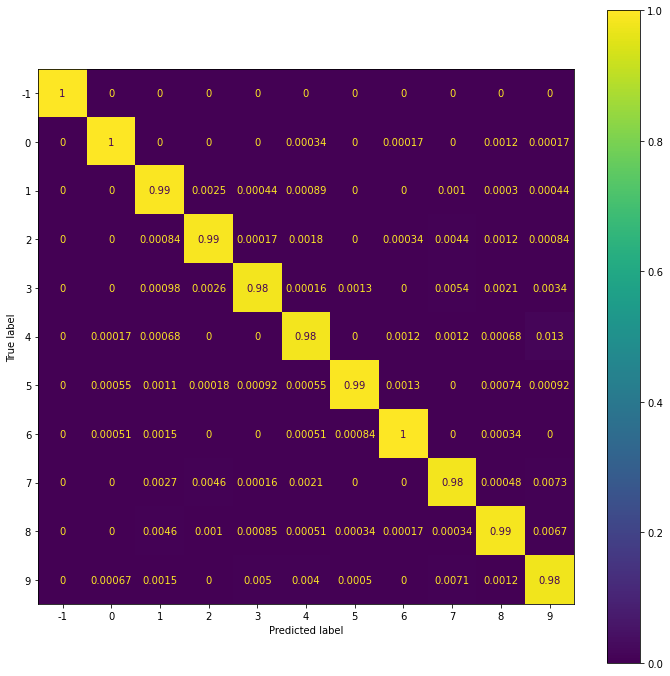

In [6]:
y_hat_train = rf.predict(X_train)
evaluate(y_train, y_hat_train)

              precision    recall  f1-score   support

          -1       0.98      1.00      0.99      1000
           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.95      0.96      0.95      1032
           3       0.95      0.95      0.95      1010
           4       0.97      0.95      0.96       982
           5       0.97      0.95      0.96       892
           6       0.97      0.98      0.97       958
           7       0.97      0.94      0.95      1028
           8       0.96      0.94      0.95       974
           9       0.93      0.95      0.94      1009

    accuracy                           0.96     11000
   macro avg       0.96      0.96      0.96     11000
weighted avg       0.96      0.96      0.96     11000



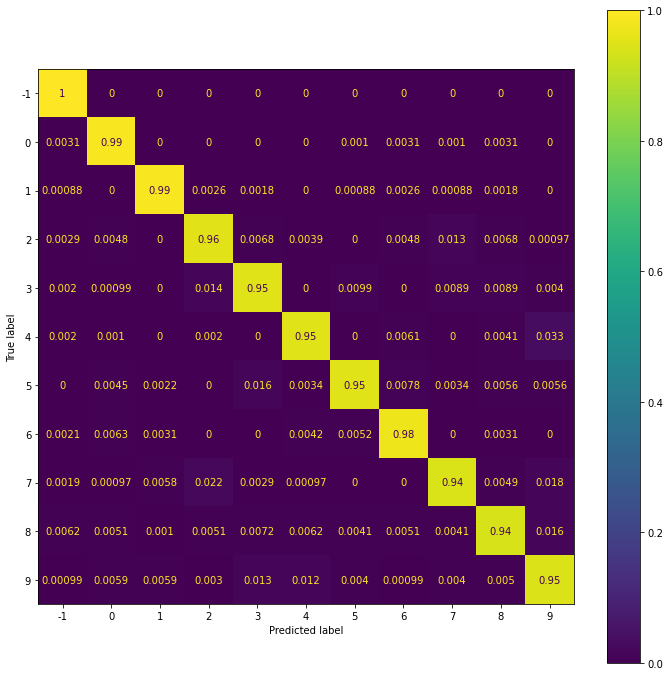

In [7]:
X_test, y_test = load_test(config)
if config.with_unsupervised_learning_trick:
    X_test, y_test = unsupervised_learning_trick(X_test, y_test, n_unknowns=config.test_n_unknowns)
y_hat_test = rf.predict(X_test)
y_prob_test = rf.predict_proba(X_test)
evaluate(y_test, y_hat_test)

# Normal Images

Total 10000

True Label 7
Predicted Label 7
Predicted Probability 0.9793516538192172


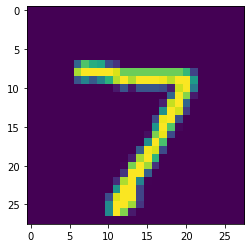

True Label 2
Predicted Label 2
Predicted Probability 0.7504016701535301


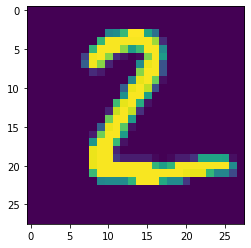

True Label 1
Predicted Label 1
Predicted Probability 0.9738755382964321


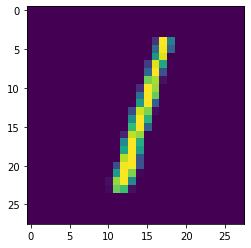

True Label 0
Predicted Label 0
Predicted Probability 0.9352415713509062


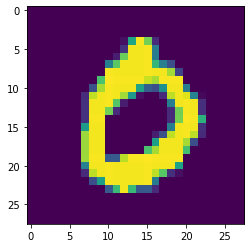

True Label 4
Predicted Label 4
Predicted Probability 0.8931474951134427


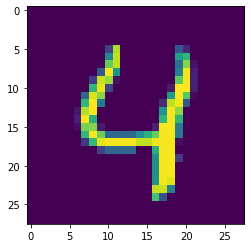

True Label 1
Predicted Label 1
Predicted Probability 0.9789041021483729


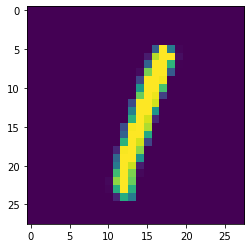

True Label 4
Predicted Label 4
Predicted Probability 0.6839885479117203


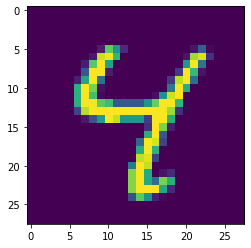

True Label 9
Predicted Label 9
Predicted Probability 0.5554514860202037


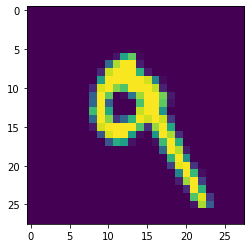

True Label 5
Predicted Label 5
Predicted Probability 0.2591955406086213


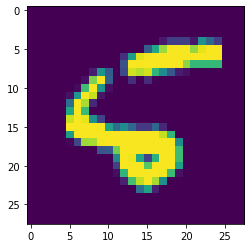

True Label 9
Predicted Label 9
Predicted Probability 0.7983953847065036


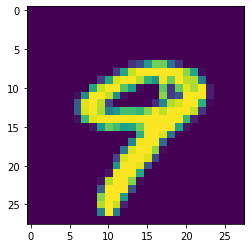

In [8]:
not_unknown_mask = y_test != -1
print("Total", sum(not_unknown_mask))
print()
eyeball(
    X=X_test[not_unknown_mask],
    y=y_test[not_unknown_mask],
    y_hat=y_hat_test[not_unknown_mask],
    y_prob=y_prob_test[not_unknown_mask]
)

# Images Predicted as Unknown.

Total 1022

True Label 2
Predicted Label -1
Predicted Probability 0.2222329669340371


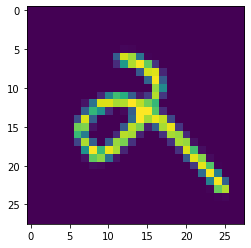

True Label 8
Predicted Label -1
Predicted Probability 0.1951142756865323


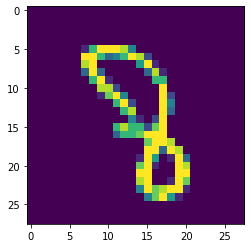

True Label 8
Predicted Label -1
Predicted Probability 0.17248933928188173


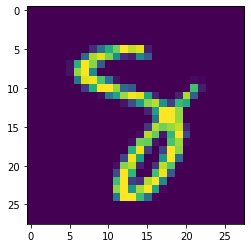

True Label 7
Predicted Label -1
Predicted Probability 0.22828327150130867


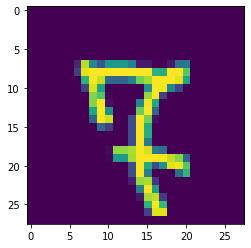

True Label 8
Predicted Label -1
Predicted Probability 0.30708866966945164


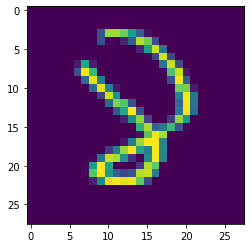

True Label 4
Predicted Label -1
Predicted Probability 0.19787391342365956


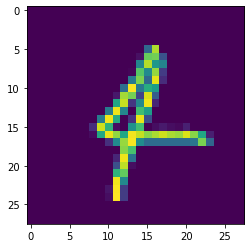

True Label 8
Predicted Label -1
Predicted Probability 0.225606998174814


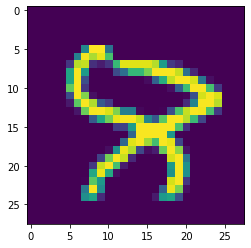

True Label 8
Predicted Label -1
Predicted Probability 0.22178239104303824


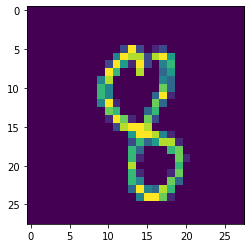

True Label 0
Predicted Label -1
Predicted Probability 0.20292505069056974


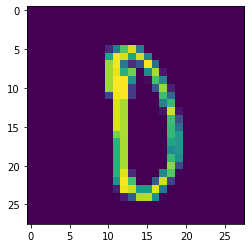

True Label 1
Predicted Label -1
Predicted Probability 0.16867325565278937


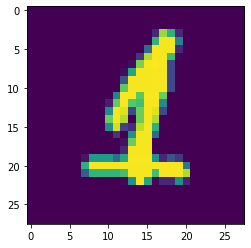

In [12]:
unknown_mask = y_hat_test == -1
print("Total", sum(unknown_mask))
print()
eyeball(
    X=X_test[unknown_mask],
    y=y_test[unknown_mask],
    y_hat=y_hat_test[unknown_mask],
    y_prob=y_prob_test[unknown_mask],
)